In [2]:
#import packages
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
import pandas as pd
import math
import scipy.spatial.distance as distance
import os.path
import csv
import glob
import h5py as h5py
import cv2
import imageio
import matplotlib.pyplot as plt
from mlxtend.image import extract_face_landmarks

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score

from shutil import copy

import re
from matplotlib.pyplot import imshow
from PIL import Image

%matplotlib inline

In [ ]:
def captureFrame(sec):
    start = 180000
    vidcap.set(cv2.CAP_PROP_POS_MSEC, start + sec*1000)
    hasFrames,image = vidcap.read()
    return hasFrames, image

In [ ]:
data, labels = [], []

for j in range(31, 37):
    for i in range(0, 11, 5):
        video = 'Fold3_part2/' + str(j) +'/' + str(i) + '.mp4'
        vidcap = cv2.VideoCapture(video)        
        sec = 0
        frameRate = 1
        success, image = captureFrame(sec)
        count = 0
        
        while success and count < 240:
            landmarks = extract_face_landmarks(image)
            
            if landmarks is not None and sum(sum(landmarks)) != 0:
                cv2.imwrite("images/frame_%d_%d_%d.jpg" % (j, i, count), image)
                count += 1
                data.append(landmarks)
                labels.append([i])
                sec = sec + frameRate
                sec = round(sec, 2)
                success, image = captureFrame(sec)
            else:
                sec = sec + frameRate
                sec = round(sec, 2)
                success, image = captureFrame(sec)
                print('was not detected')
                
        print('Feature extraction for %s is done.' % video)

In [ ]:
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar

def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

def mouth_eye_ratio(eye):
    mouth_ratio = mouth_aspect_ratio(eye)
    eye_ratio = eye_aspect_ratio(eye)
    mouthI = mouth_ratio/eye_ratio
    return mouthI

In [ ]:
data = np.array(data)
labels = np.array(labels)
featureList = [] 

for d in data:
    eye = d[36:68]
    eye_ratio = eye_aspect_ratio(eye)
    mouth_ratio = mouth_aspect_ratio(eye)
    circ = circularity(eye)
    mouth_eye = mouth_eye_ratio(eye)
    featureList.append([eye_ratio, mouth_ratio, circ, mouth_eye])

features = np.array(featureList)
print(features.shape, labels.shape)

In [ ]:
# change file name to save 
np.save(open('Data.npy', 'wb'), data)
np.save(open('Fold3_part2_features.npy', 'wb'),features)
np.save(open('Fold3_part2_labels.npy', 'wb'),labels)
np.savetxt("Fold3_part2_features.csv", features, delimiter = ",")
np.savetxt("Fold3_part2_labels.csv", labels, delimiter = ",")

In [3]:
# how to load npy data file to colab
# data = np.load('Data.npy')
df_features = pd.read_csv("Fold3_part2_features.csv", names=["EAR", "MAR", "Circularity", "MOE"])
df_labels = pd.read_csv("Fold3_part2_labels.csv", names=["Y"])

In [4]:
df = pd.concat([pd.concat([df_features], ignore_index=True), pd.concat([df_labels], ignore_index=True)], axis=1)
df

,EAR,MAR,Circularity,MOE,Y
0,0.295585,0.645828,0.449215,2.184918,0.0
1,0.197852,0.780875,0.355239,3.946756,0.0
2,0.303230,0.812615,0.436240,2.679867,0.0
3,0.244438,0.756843,0.393171,3.096259,0.0
4,0.300713,0.747531,0.457257,2.485865,0.0
...,...,...,...,...,...
3595,0.163529,0.963825,0.309566,5.893894,10.0
3596,0.291400,0.939786,0.426871,3.225075,10.0
3597,0.306107,1.042561,0.428721,3.405866,10.0
3598,0.301756,0.958100,0.441118,3.175086,10.0


In [6]:
# pd.set_option('display.max_rows', 5000)
# create a binary classification problem
df_bin = df[df["Y"] != 5.0].copy()
df_bin.loc[df.Y == 0.0, "Y"] = int(0)
df_bin.loc[df.Y == 10.0, "Y"] = int(1)

train_percentage = 3.7/6
train_samples = int(len(df_bin) * train_percentage)
test_samples = len(df_bin) - train_samples

train = df_bin[:train_samples]
test = df_bin[-test_samples:]

X_train = train.drop("Y", axis=1)
y_train = train["Y"]

X_test = test.drop(["Y"], axis=1)
y_test = test["Y"]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1480, 4) (1480,) (920, 4) (920,)


## Binary Classification

In [7]:
def average(y_pred):
    for i in range(len(y_pred)):
        if i % len(y_pred) == 0 or (i+1) % len(y_pred) == 0:
            pass
        else: 
            average = float(y_pred[i-1] +  y_pred[i] + y_pred[i+1])/3
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0

    return y_pred

### KNN

In [8]:
acc_KNN = []

for i in range(1, 30):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train) 
    pred_KN = average(neigh.predict(X_test))
    y_score = neigh.predict_proba(X_test)[:,1]
    acc_KNN.append(accuracy_score(y_test, pred_KN))
    
acc_KNN.index(max(acc_KNN)) + 1, max(acc_KNN)

(11, 0.7608695652173914)

### Random Forest

In [9]:
acc_RF = []
max_depth = []

for i in range(1, 10):
    clf_RF = RandomForestClassifier(max_depth=i)
    clf_RF.fit(X_train, y_train) 
    pred_RF = average(clf_RF.predict(X_test))
    acc_RF.append(accuracy_score(pred_RF, y_test))
    max_depth.append(i)
    
acc_RF.index(max(acc_RF)) + 1, max(acc_RF)

(6, 0.8021739130434783)

### SVM

In [10]:
svm = SVC()
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)
pred_svm = average(pred_svm)

print(accuracy_score(y_test, pred_svm))

0.6663043478260869


## Multi-class Classification

In [11]:
df_multi = df.copy()
df_multi.loc[df.Y == 0.0, "Y"] = int(0)
df_multi.loc[df.Y == 5.0, "Y"] = int(1)
df_multi.loc[df.Y == 10.0, "Y"] = int(2)

split_percentage = 3.7 / 6
train_samples = int(len(df_multi) * split_percentage)
test_samples = len(df_multi) - train_samples

train = df_multi[:train_samples]
test = df_multi[-test_samples:]

# training set
X_train = train.drop("Y", axis=1)
y_train = train["Y"]

# testing set
X_test = test.drop("Y", axis=1)
y_test = test["Y"]

# X = df_multi.loc[:, df_multi.columns != "Y"]
# y = df_multi["Y"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=(3.7/6))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2220, 4) (2220,) (1380, 4) (1380,)


### KNN

In [12]:
acc_knn = []

for i in range(1,30):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train) 
    pred_KN = average(neigh.predict(X_test))
    acc_knn.append(accuracy_score(y_test, pred_KN))
    
acc_knn.index(max(acc_knn)) + 1, max(acc_knn)

(3, 0.3847826086956522)

### Random Forest

In [13]:
acc_RF = []
max_depth = []

for i in range(1, 10):
    clf_RF = RandomForestClassifier(max_depth=i)
    clf_RF.fit(X_train, y_train) 
    pred_RF = average(clf_RF.predict(X_test))
    acc_RF.append(accuracy_score(pred_RF, y_test))
    max_depth.append(i)
    
acc_RF.index(max(acc_RF)) + 1, max(acc_RF)

(4, 0.4449275362318841)

### SVM

In [14]:
svm = SVC(decision_function_shape="ovr")

svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)
pred_svm = average(pred_svm)

print(accuracy_score(y_test, pred_svm))

0.36666666666666664


## CNN

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [16]:
new_dir = "drowsy_vs_non_drowsy/"

if not os.path.isdir(new_dir):
    os.mkdir(new_dir)
    r = "^frame_\d{2}_5_\d{1,3}.jpg$"
    
    for img in os.listdir("images/"):
        if not re.match(r, img):
            copy("images/" + img, new_dir)

In [122]:
class DrowinessDataset(Dataset):
    # 0.7/0.3 default split
    def __init__(self, transform, train_split=0.7, mode="train"):
        if mode not in ["train", "val"]:
            raise ValueError('Invalid Split %s' % mode)
            
        self.transform = transform
        self.mode = mode
        self.X = {}
        self.y = {}
        
        r =  new_dir + "frame_\d{2}_0_\d{1,3}.jpg$"
        samples = [new_dir + img for img in os.listdir(new_dir)]
        labels = [0 if re.match(r, img) else 1 for img in samples]
        
        self.X["train"], self.X["val"], self.y["train"], self.y["val"] = train_test_split(
            samples, labels, test_size=0.30, random_state=42, stratify=labels)
        
    def __len__(self):
        return len(self.X[self.mode])
    
    def __getitem__(self, index):
        img = Image.open(self.X[self.mode][index])
        img = self.transform(img)
        
        return img, self.y[self.mode][index]

In [123]:
tforms = transforms.Compose([transforms.Resize((256, 256)),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_set = DrowinessDataset(transform=tforms)
train_dataloader = DataLoader(train_set, batch_size=8, shuffle=True)

val_set = DrowinessDataset(transform=tforms, mode="val")
val_dataloader = DataLoader(val_set, batch_size=8, shuffle=False)

In [124]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, padding=1, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, padding=1, kernel_size=3)
        self.conv_dropout = nn.Dropout2d(p=0.25)
        
        self.fc1 = nn.Linear(40960, 4096)
        self.fc2 = nn.Linear(4096, 1)
        self.fc_dropout = nn.Dropout(p=0.25)
        
        self.reset_params()
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = self.conv_dropout(x)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc_dropout(x)
        x = torch.sigmoid(x)
        x = torch.sigmoid(self.fc2(x))
        
        return x
    
    @staticmethod
    def weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weights_init(m)

In [126]:
def training_loop(model, num_epochs, criterion, optimizer, metrics):
    for epoch in range(num_epochs + 1):
        train_loss, val_loss = [], []
        correct, total = 0, 0

        model.train()
        for i, (imgs, labels) in enumerate(train_dataloader):
            imgs, labels = imgs.to(device=device), labels.to(device=device, dtype=torch.float32)
            optimizer.zero_grad()

            output = model(imgs).T[0]

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

            predicted = torch.round(output)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            
        train_acc = correct / total
        metrics["train_loss"].append(np.mean(train_loss))
        metrics["train_acc"].append(train_acc)
        correct, total = 0, 0

        model.eval()
        for i, (imgs, labels) in enumerate(val_dataloader):
            with torch.no_grad():
                imgs, labels = imgs.to(device=device), labels.to(device=device, dtype=torch.float32)
                
                output = model(imgs).T[0]

                loss = criterion(output, labels)
                val_loss.append(loss.item())

                predicted = torch.round(output)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        val_acc = correct / total
        metrics["val_loss"].append(np.mean(val_loss))
        metrics["val_acc"].append(val_acc)
        
        print("Epoch: {}, Train loss: {}, Train acc: {}, Val loss: {}, Val acc: {}".format(
            epoch, np.mean(train_loss), train_acc, np.mean(val_loss), val_acc))

In [127]:
model = Net().to(device)
lr = 1e-4
num_epochs = 5
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

metrics = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

training_loop(model, num_epochs, criterion, optimizer, metrics)

Epoch: 0, Train loss: 0.05802762513714177, Train acc: 0.9863095238095239, Val loss: 0.011176064346606533, Val acc: 0.9958333333333333
Epoch: 1, Train loss: 0.007139632766622873, Train acc: 0.9988095238095238, Val loss: 0.01375758661953215, Val acc: 0.9972222222222222
Epoch: 2, Train loss: 0.004570832732133568, Train acc: 0.9982142857142857, Val loss: 0.013505196025006525, Val acc: 0.9972222222222222
Epoch: 3, Train loss: 0.002137604061447616, Train acc: 0.9994047619047619, Val loss: 0.014066557851523005, Val acc: 0.9972222222222222
Epoch: 4, Train loss: 0.0020130468554617393, Train acc: 0.9994047619047619, Val loss: 0.014386808647355389, Val acc: 0.9972222222222222
Epoch: 5, Train loss: 0.0012265068771306514, Train acc: 1.0, Val loss: 0.013129880000997218, Val acc: 0.9972222222222222


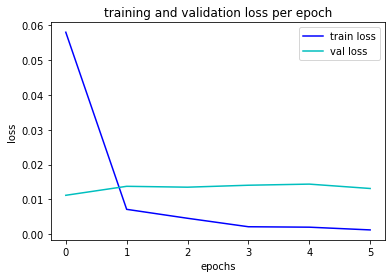

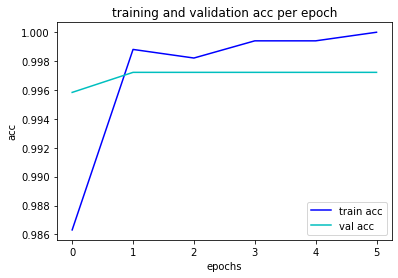

In [129]:
def plot_loss(metrics):
    plt.plot(np.squeeze(metrics["train_loss"]), '-b', label="train loss")
    plt.plot(np.squeeze(metrics["val_loss"]), '-c', label="val loss")
    plt.legend(loc="upper right")
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.title("training and validation loss per epoch")
    plt.show()
    
def plot_acc(metrics):
    plt.plot(np.squeeze(metrics["train_acc"]), '-b', label="train acc")
    plt.plot(np.squeeze(metrics["val_acc"]), '-c', label="val acc")
    plt.legend(loc="lower right")
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.title("training and validation acc per epoch")
    plt.show()

plot_loss(metrics)
plot_acc(metrics)